# Imports and setup.

In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np

import algorithms
import loss_functions

%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.style.use('ggplot')
l_alpha = [0.8, 0.7, 0.6, 0.5, 0.4]
l_alpha = [1, 1, 1, 1, 1]

logging.basicConfig(
    format = '%(asctime)s %(filename)s:%(lineno)d %(message)s',
    datefmt = '%I:%M:%S %p',
    level = logging.INFO
)

rng = np.random.default_rng()

# Set problem parameters.

In [2]:
m = 10
T = 200

# Create loss functions.

In [3]:
l_fn = loss_functions.create_rademacher_functions(T, m)
l_fn = loss_functions.functions_0(T, m)

# Find the benchmark.

In [4]:
opt = algorithms.optimal_benchmark(
    l_fn,
    rng.random(size = 1),
    T,
    m
)
cum_loss_opt = np.cumsum([l_fn[t]([opt.x] * m) for t in range(T)])

09:49:35 AM algorithms.py:24 Optimal benchmark.
09:49:36 AM algorithms.py:33 	x: [0.3]
09:49:36 AM algorithms.py:34 	success: True
09:49:36 AM algorithms.py:35 	message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
09:49:36 AM algorithms.py:36 	fun: 4.999997496734938e-14


# FTRL.

In [5]:
l_ftrl_res, l_cum_loss_alg = [], []

for mode in algorithms.mode_strs:

    init_fn = getattr(algorithms, f'ftrl_init_{mode}')
    z_0 = init_fn(m)

    eta = None
    eta = 1 / np.sqrt(T)

    if mode == 0 or mode == 1:
        eta /= m**(1/2)
    elif mode == 2 or mode == 3 or mode == 4:
        eta /= m**(3/4)

    l_ftrl_res.append(algorithms.ftrl(
        l_fn,
        z_0,
        T,
        m,
        eta,
        mode
    ))

    cum_loss_alg = np.cumsum([res.l for res in l_ftrl_res[-1]])
    l_cum_loss_alg.append(cum_loss_alg)

09:49:36 AM algorithms.py:61 mode 0: FTRL on f_t and project by taking the average.
09:49:38 AM algorithms.py:61 mode 1: FTRL on f_t and project onto the most recent decision.
09:49:41 AM algorithms.py:61 mode 2: FTRL on \circfn f_t.
09:49:46 AM algorithms.py:61 mode 3: FTRL on f_{1:t}((x, x_{t-1}, \dots, x_{t-m+1})).
09:49:47 AM algorithms.py:61 mode 4: FTRL on \circfn f_t plus \| (x, \dots, x) - (x, x_{t-1}, \dots, x_{t-m+1}) \|_2^2.


# Plot.

### Regret.

In [6]:
l_regret = [
    cum_loss_alg - cum_loss_opt for cum_loss_alg in l_cum_loss_alg
]

In [7]:
for (i, mode) in enumerate(algorithms.mode_strs):
    logging.info(f'Regret for mode {mode}: {l_regret[i][-1]}')

09:49:53 AM 3634568286.py:2 Regret for mode 0: 37.24279452328229
09:49:53 AM 3634568286.py:2 Regret for mode 1: 37.24279449909114
09:49:53 AM 3634568286.py:2 Regret for mode 2: 11.395719843236108
09:49:53 AM 3634568286.py:2 Regret for mode 3: 55.46803322244387
09:49:53 AM 3634568286.py:2 Regret for mode 4: 11.395719644340135


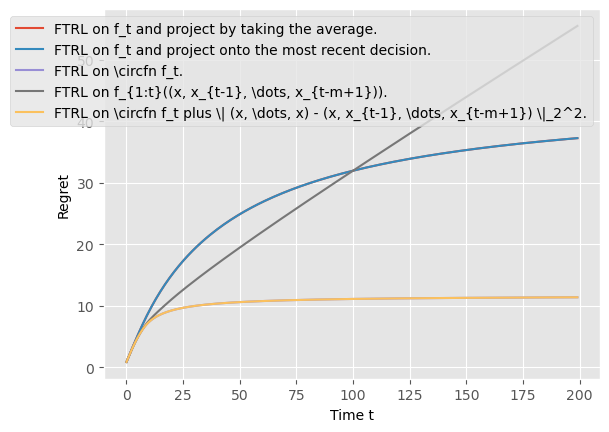

In [8]:
for (i, mode) in enumerate(algorithms.mode_strs):
    label = algorithms.mode_strs[mode]
    plt.plot(l_regret[i], label = label, alpha = l_alpha[i])
plt.xlabel('Time t')
plt.ylabel('Regret')
plt.legend()
plt.show()

### $\| h_t - (x_t, \dots, x_t) \|$.

In [9]:
l_diffs = []
for (i, mode) in enumerate(algorithms.mode_strs):

    diffs = []

    for t in range(T):

        h_t = [0] * max(0, m - t - 1) + \
            [l_ftrl_res[i][s].x for s in range(max(0, t - m + 1), t + 1)]
        x_t_history = [l_ftrl_res[i][t].x] * len(h_t)
        diff = np.linalg.norm(
            np.array(h_t) - np.array(x_t_history)
        )
        
        diffs.append(diff)

    diffs = np.array(diffs)
    l_diffs.append(diffs)

In [10]:
for (i, mode) in enumerate(algorithms.mode_strs):
    logging.info(
        f'Sum of norm differences between histories for mode {mode}: {np.sum(l_diffs[i])}'
    )

09:49:54 AM 969779365.py:2 Sum of norm differences between histories for mode 0: 4.138365116001435
09:49:54 AM 969779365.py:2 Sum of norm differences between histories for mode 1: 4.138365145611604
09:49:54 AM 969779365.py:2 Sum of norm differences between histories for mode 2: 4.940671847605373
09:49:54 AM 969779365.py:2 Sum of norm differences between histories for mode 3: 2.589000377786671
09:49:54 AM 969779365.py:2 Sum of norm differences between histories for mode 4: 4.940671842620553


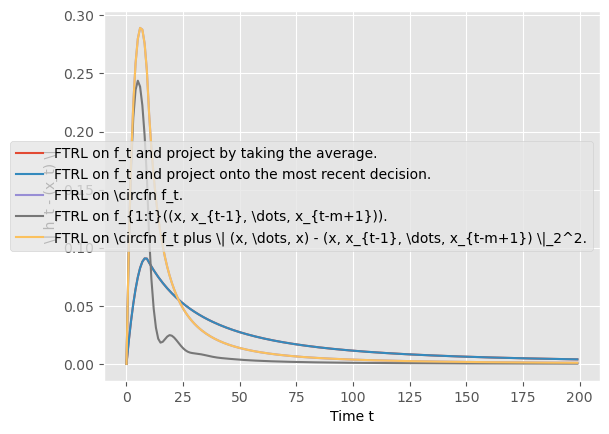

In [11]:
for (i, mode) in enumerate(algorithms.mode_strs):
    label = algorithms.mode_strs[mode]
    plt.plot(l_diffs[i], label = label, alpha = l_alpha[i])
plt.xlabel('Time t')
plt.ylabel('\| h_t - (x_t) \|')
plt.legend()
plt.show()

### $\| x_t^{(0)} - x_t^{(2)} \|$, where $x_t^{(i)}$ denotes the iterate in round $t$ produced by FTRL in mode $i$.

In [12]:
l_diff = [
    np.linalg.norm(l_ftrl_res[0][i].x - l_ftrl_res[2][i].x) \
        for i in range(T)
]

In [13]:
logging.info(
    f'Sum of norm differences between iterates for modes 0 and 2: {np.sum(l_diff)}'
)

09:49:54 AM 1198891545.py:1 Sum of norm differences between iterates for modes 0 and 2: 14.992374232775099


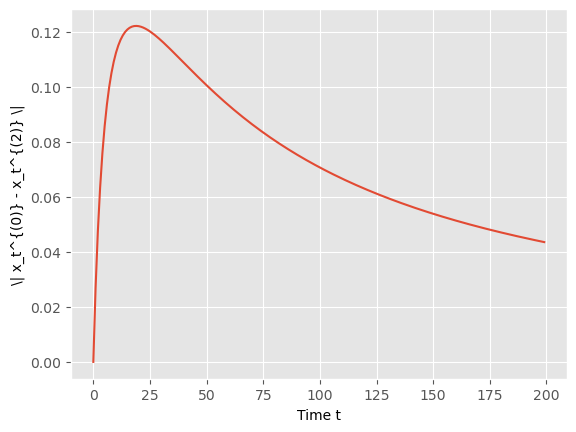

In [14]:
plt.plot(l_diff)
plt.xlabel('Time t')
plt.ylabel('\| x_t^{(0)} - x_t^{(2)} \|')
plt.show()

In [15]:
logging.info(f'Decisions for mode 0: {[res.x for res in l_ftrl_res[0][:]]}')
logging.info(f'Decisions for mode 2: {[res.x for res in l_ftrl_res[2][:]]}')

09:49:54 AM 3614189879.py:1 Decisions for mode 0: [-4.556901988033627e-09, 0.006561479761945051, 0.012842086678707057, 0.018859474560195804, 0.024629849811232903, 0.030168116634713926, 0.03548800303444677, 0.04060217445364998, 0.04552234239073345, 0.05025933501276671, 0.0548231933057509, 0.05922324513109042, 0.06346815140961569, 0.06756597284738611, 0.0715242243061746, 0.0753499206580587, 0.07904960877433197, 0.08262941552792288, 0.08609506557175621, 0.08945194922879471, 0.09270509256947715, 0.09585924072446367, 0.09891884754627792, 0.10188808291790057, 0.10477091323719465, 0.1075710475509349, 0.11029199218887724, 0.11293706435963106, 0.11550938510777642, 0.11801192718742434, 0.12044748176531297, 0.12281871130686121, 0.12512811735734555, 0.12737810873343386, 0.12957092223357003, 0.13170873499056981, 0.13379357804259912, 0.1358274007143479, 0.13781204748894643, 0.13974927215196054, 0.14164078920565337, 0.14348815867151105, 0.14529293129553372, 0.14705653924118192, 0.14878039605130255, 0

### $\sum_{s=1}^t fcirc_t(x_t^{(0)}) - fcirc_t(x_t^{(2)})$, where $x_t^{(i)}$ denotes the iterate in round $t$ produced by FTRL in mode $i$.

In [16]:
l_diff = [
    l_fn[i]([l_ftrl_res[0][i].x] * m) - l_fn[i]([l_ftrl_res[2][i].x] * m) \
        for i in range(T)
]
l_diff = np.cumsum(l_diff)

In [17]:
logging.info(
    f'Sum of norm differences between iterates for modes 0 and 2: {l_diff[-1]}'
)

09:49:54 AM 688310818.py:1 Sum of norm differences between iterates for modes 0 and 2: 25.980367361960727


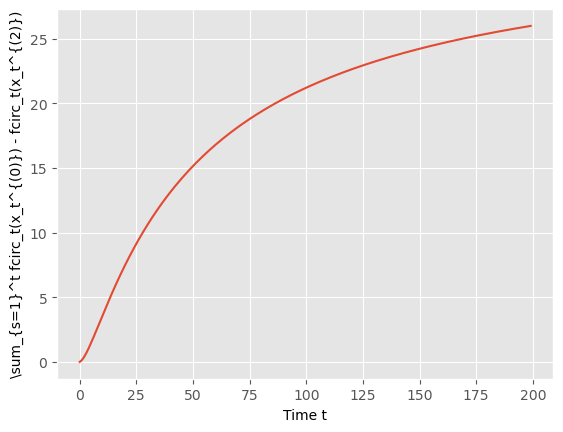

In [18]:
plt.plot(l_diff)
plt.xlabel('Time t')
plt.ylabel('\sum_{s=1}^t fcirc_t(x_t^{(0)}) - fcirc_t(x_t^{(2)})')
plt.show()

### Iterates.

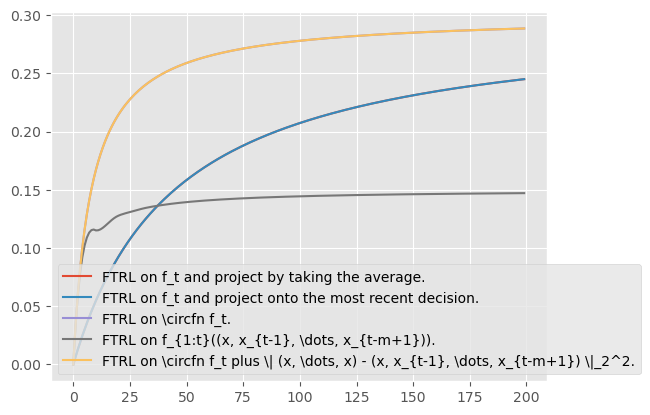

In [19]:
for (i, mode) in enumerate(algorithms.mode_strs):
    label = algorithms.mode_strs[mode]
    plt.plot([res.x for res in l_ftrl_res[i][:]], label = label, alpha = l_alpha[i])
plt.legend()
plt.show()